In [1]:
import sys
sys.path.append('..')
import sklearn
import wandb
from tsai.basics import *
from swdf.losses import *
from swdf.utils import sliding_window_generator
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback


In [2]:
config_base = yaml2dict('./config/base.yaml', attrdict=True)
config_solfsmy = yaml2dict('./config/solfsmy.yaml', attrdict=True)
config_solfsmy = config_solfsmy.train
# Merge the two configs (the second one overrides the first one for any keys that are present in both)
config = AttrDict({**config_base, **config_solfsmy})
# Add the architecture config
if config.arch_name.lower() == 'patchtst':
    config.learner1, config.learner2 = AttrDict(), AttrDict()
    config.learner1.arch = yaml2dict('./config/patchtst.yaml', attrdict=True)
    config.learner2.arch = yaml2dict('./config/patchtst.yaml', attrdict=True)
else:
    config.arch = AttrDict()

config.learner1.init_weights = config.init_weights
config.learner2.init_weights = config.init_weights
config.pop('init_weights', None)

False

In [3]:
run = wandb.init(project=config.wandb.project, 
                 config=config,
                 group=config.wandb.group,
                 mode=config.wandb.mode, 
                 anonymous='never') if config.wandb.enabled else None
config = dict2attrdict(run.config) if config.wandb.enabled else config

In [4]:
config

```json
{ 'add_time_channels': False,
  'arch_config_file': 'config/patchtst.yaml',
  'arch_name': 'PatchTST',
  'bs': 32,
  'data_columns_fcst': ['F10', 'S10', 'M10', 'Y10'],
  'data_path': '../data/SOLFSMY.TXT',
  'data_url': 'https://sol.spacenvironment.net/JB2008/indices/SOLFSMY.TXT',
  'deltaHL': 2.0,
  'horizon': 6,
  'is_optuna_study': False,
  'learner1': { 'arch': { 'decomposition': True,
                          'individual': True,
                          'padding_patch': True,
                          'revin': True},
                'init_weights': False},
  'learner2': { 'arch': { 'decomposition': True,
                          'individual': True,
                          'padding_patch': True,
                          'revin': True},
                'init_weights': False},
  'lookback': 36,
  'lr_max': None,
  'n_epoch': 30,
  'partial_n': 0.1,
  'seed': 42,
  'test_end_datetime': '2018-12-31 12:00:00',
  'test_start_datetime': '2012-10-01 12:00:00',
  'valid_start_datetime': '2018-01-01 12:00:00',
  'wandb': { 'enabled': False,
             'group': None,
             'log_learner': True,
             'mode': 'offline',
             'project': 'swdf'}}
```

In [5]:
df = load_object("preprocessed_data/dataframes/solfsmy.pkl")
segments = load_object("tmp/data/segments.pkl")
best_comb = load_object("tmp/data/best_comb.pkl")
data_columns = ['F10', 'S10', 'M10', 'Y10']

test_period = (df.Date >= config.test_start_datetime) & (df.Date <= config.test_end_datetime)

In [6]:
a = np.arange(0,len(segments))
train_comb = list(np.setdiff1d(a, best_comb))

X_val, y_val, split_val = sliding_window_generator(df, 0, data_columns=data_columns, config=config, comb=best_comb, segments=segments)
X_train, y_train, split_train = sliding_window_generator(df, split_val[-1]+1, data_columns=data_columns, config=config, comb=train_comb, segments=segments)
X_test, y_test, split_test = sliding_window_generator(df[test_period], split_train[-1]+1, data_columns=data_columns, config=config) 

X = np.concatenate([X_val, X_train, X_test])
y = np.concatenate([y_val, y_train, y_test])

splits = (split_train, split_val, split_test)

In [7]:
thresholds = yaml2dict("distributions/thresholds.yaml")
weights = load_object("tmp/loss_param/solfsmy_weights.pkl")

preproc_pipe = load_object("tmp/pipes/preproc_pipe.pkl")
exp_pipe = load_object("tmp/pipes/exp_pipe.pkl")

epoch,train_loss,valid_loss,loss_low,loss_moderate,loss_elevated,loss_high,time
0,1.303035,1.707381,0.111924,0.391850,0.205431,0.998176,00:02
1,1.151600,1.567953,0.119826,0.371046,0.189916,0.887164,00:02
2,1.099677,1.730994,0.144866,0.421220,0.206115,0.958794,00:02
3,1.075798,1.809588,0.146692,0.428938,0.202779,1.031180,00:02
4,1.097206,1.796045,0.137740,0.431538,0.212187,1.014580,00:02
5,1.134291,2.379653,0.182530,0.618174,0.287364,1.291584,00:02
6,1.142081,2.332158,0.172114,0.573353,0.287140,1.299550,00:02
7,1.147995,1.767536,0.120073,0.411665,0.201906,1.033892,00:02
8,1.184072,5.377099,0.317107,1.198419,0.578409,3.283163,00:02
9,1.201499,2.778623,0.203166,0.715649,0.326668,1.533141,00:02


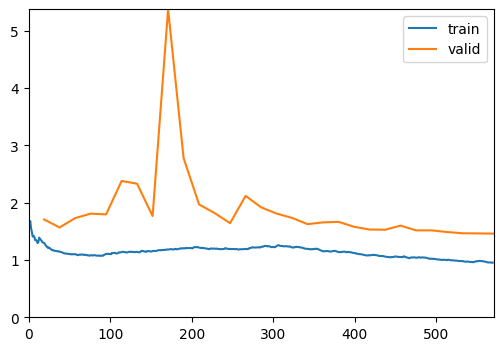

#params: 12729412


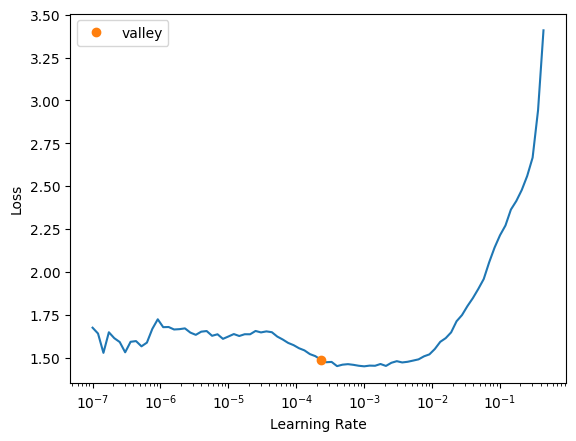

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loss = wMAELoss(thresholds, weights).to(device)
metrics = LossMetrics(loss, data_columns).get_metrics()

wandb_callback = WandbCallback(log_preds=False)
cbs = L(wandb_callback) if config.wandb.enabled else L()
learner1 = TSForecaster(X, y, splits=splits, batch_size=config.bs,
                     pipelines=[preproc_pipe, exp_pipe], 
                     arch=config.arch_name, 
                     metrics=metrics,
                     loss_func=loss,
                     arch_config=dict(config.learner1.arch), 
                     init=config.learner1.init_weights,
                     cbs= cbs + ShowGraphCallback(), 
                     partial_n=config.partial_n)
lr_max = learner1.lr_find().valley if config.lr_max is None else config.lr_max

learner1.fit_one_cycle(n_epoch=config.n_epoch, lr_max=config.lr_max)
print(f"#params: {sum(p.numel() for p in learner1.model.parameters())}") 

epoch,train_loss,valid_loss,loss_low,loss_moderate,loss_elevated,loss_high,time
0,1.436296,1.795442,0.116249,0.409664,0.214624,1.054905,00:02
1,1.199584,1.570149,0.120051,0.364516,0.185305,0.900278,00:02
2,1.170029,1.631700,0.128271,0.395168,0.192417,0.915845,00:02
3,1.104881,1.673607,0.134942,0.390602,0.197590,0.950472,00:02
4,1.123575,1.904879,0.144420,0.477629,0.228815,1.054015,00:02
5,1.116076,1.825448,0.143470,0.446864,0.204861,1.030254,00:02
6,1.151475,2.203249,0.177185,0.559925,0.276388,1.189752,00:02
7,1.159109,2.093861,0.158535,0.538554,0.262648,1.134124,00:02
8,1.170342,2.154368,0.153199,0.522700,0.264640,1.213828,00:02
9,1.187437,2.268310,0.165953,0.558258,0.274016,1.270083,00:02


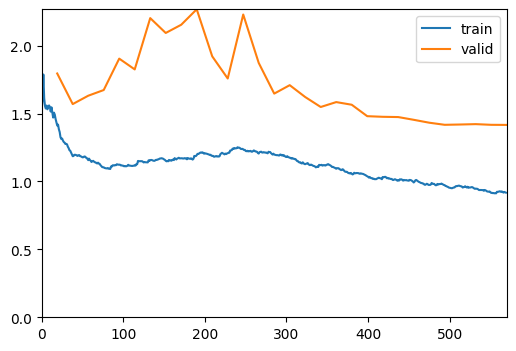

#params: 12729412


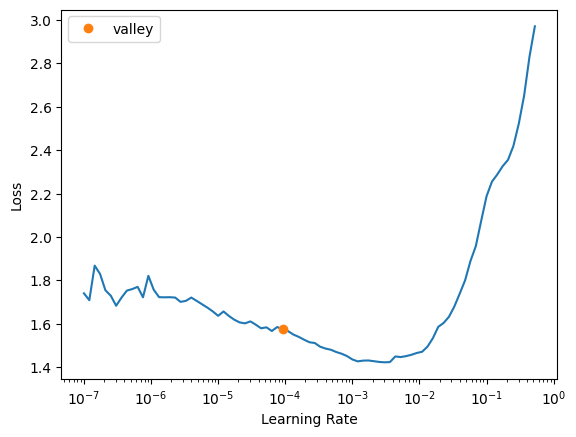

In [9]:
loss = wMAELoss(thresholds, weights).to(device)
metrics = LossMetrics(loss, data_columns).get_metrics()

learner2 = TSForecaster(X, y, splits=splits, batch_size=config.bs,
                     pipelines=[preproc_pipe, exp_pipe], 
                     arch=config.arch_name, 
                     metrics=metrics,
                     loss_func=loss,
                     arch_config=dict(config.learner2.arch), 
                     init=config.learner2.init_weights,
                     cbs= cbs + ShowGraphCallback(), 
                     partial_n=config.partial_n)
lr_max = learner2.lr_find().valley if config.lr_max is None else config.lr_max

learner2.fit_one_cycle(n_epoch=config.n_epoch, lr_max=config.lr_max)
print(f"#params: {sum(p.numel() for p in learner2.model.parameters())}") 

In [10]:
# Print the validation loss and save it in case other notebooks (optuna) wants to
# use it for hyperparameter optimization
valid_loss = (learner1.validate()[0] + learner2.validate()[0]) / 2
print(valid_loss)
%store valid_loss

1.4386247396469116
Stored 'valid_loss' (float)


In [11]:
# Log the test loss to wandb
test_loss = (learner1.validate(ds_idx=2)[0] + learner2.validate(ds_idx=2)[0]) / 2
print(test_loss)

0.7786656618118286


In [12]:
# Save everything
learner1.dls.loaders += [learner1.dls.valid.new_dl(X[splits[2]], y[splits[2]])] # Add test datalaoder
learner2.dls.loaders += [learner2.dls.valid.new_dl(X[splits[2]], y[splits[2]])]

# Remove the wandb callback to avoid errors when downloading the learner
if config.wandb.enabled:
    learner1.remove_cb(wandb_callback)
    learner2.remove_cb(wandb_callback)

In [13]:
best_valid_loss = np.inf
%store -r best_valid_loss

save_all_or_best = (config.is_optuna_study and valid_loss < best_valid_loss) or not config.is_optuna_study

if save_all_or_best:
    best_valid_loss = valid_loss
    %store best_valid_loss  
    
    # Save locally and in wandb if online and enabled
    learner1.save_all(path='tmp', verbose=True, model_fname="model_learner1", learner_fname="learner_learner1") 
    learner2.save_all(path='tmp', verbose=True, model_fname="model_learner2", learner_fname="learner_learner2") 

    if run is not None and config.wandb.mode and config.wandb.log_learner:
        # Save the learner (all tmp/dls, tmp/model.pth, and tmp/learner.pkl). 
        run.log_artifact('tmp', type='learner', name='solfsmy')
    
    # Save the best model
    model = {}
    model['models'] = [learner1.model, learner2.model]
    model['lookback'] = config.lookback
    model['horizon'] = config.horizon
    model['data_columns'] = data_columns
    model['thresholds'] = yaml2dict("distributions/thresholds.yaml")

    torch.save(model, './models/best_model_ensemble_fsmy.pth')

Stored 'best_valid_loss' (float)
Learner saved:
path          = 'tmp'
dls_fname     = '['dls_0.pth', 'dls_1.pth', 'dls_2.pth', 'dls_3.pth']'
model_fname   = 'model_learner1.pth'
learner_fname = 'learner_learner1.pkl'
Learner saved:
path          = 'tmp'
dls_fname     = '['dls_0.pth', 'dls_1.pth', 'dls_2.pth', 'dls_3.pth']'
model_fname   = 'model_learner2.pth'
learner_fname = 'learner_learner2.pkl'
